
# SOLUÇÕES EM ENERGIAS RENOVÁVEIS E SUSTENTÁVEIS
## Análise de Dados e Machine Learning em Energia

Este notebook contém cinco exercícios com base em dados públicos do **ONS (Operador Nacional do Sistema Elétrico)**.  
O objetivo é explorar, analisar e modelar dados de geração de energia no Brasil, aplicando técnicas de **Python, análise de dados e aprendizado de máquina**.

### Fonte dos dados
O dataset utilizado está disponível no portal aberto do ONS:  
[CAPACIDADE_GERACAO.csv](https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/capacidade-geracao/CAPACIDADE_GERACAO.csv)

Este arquivo contém informações sobre as usinas brasileiras, incluindo:
- Tipo de geração (hidráulica, solar, eólica, térmica etc.)
- Capacidade instalada (MW)
- Data de início de operação
- Estado de localização

---



# Exercício 1 – Exploração da Matriz Energética Brasileira

### Contexto
O Brasil possui uma matriz energética diversificada. Entender a evolução da capacidade instalada por fonte é essencial para analisar a transição energética.

### Atividade
1. Carregar o dataset de capacidade de geração.  
2. Explorar as colunas e verificar os tipos de geração disponíveis.  
3. Criar gráficos de linha mostrando a evolução da capacidade instalada de cada fonte ao longo dos anos.  
4. Pergunta: Qual fonte cresceu mais nos últimos 10 anos?


In [30]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving CAPACIDADE_GERACAO.csv to CAPACIDADE_GERACAO.csv


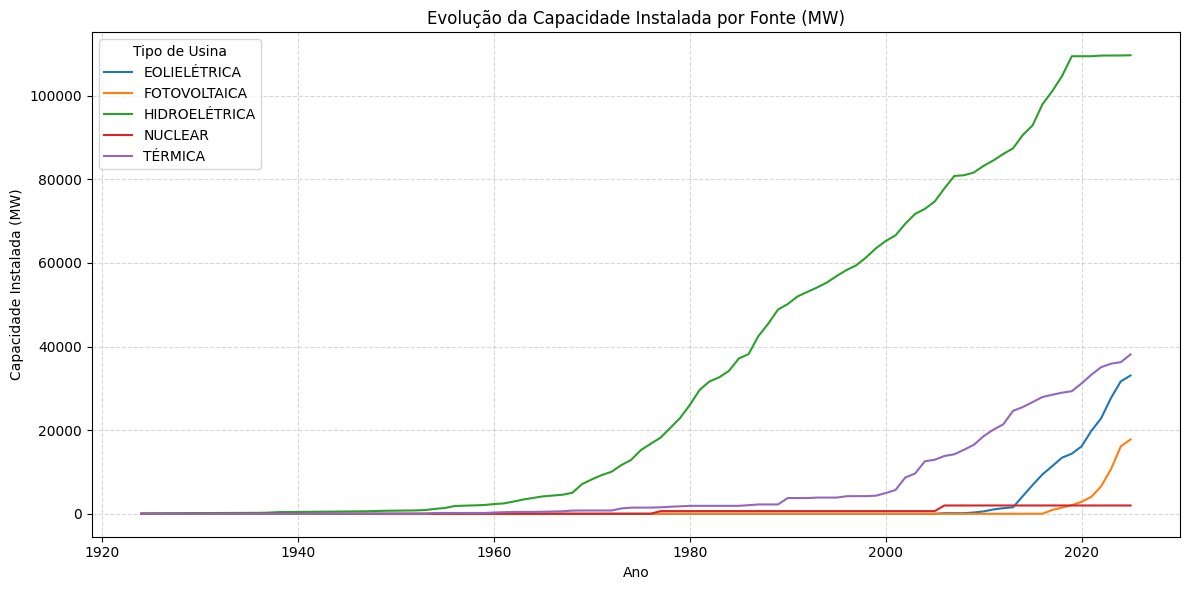

Crescimento de capacidade instalada nos últimos 10 anos (MW):
nom_tipousina
EOLIELÉTRICA     26193.445000
FOTOVOLTAICA     17773.038333
HIDROELÉTRICA    16774.051900
TÉRMICA          11406.684000
NUCLEAR              0.000000
dtype: float64

A fonte que mais cresceu nos últimos 10 anos foi: EOLIELÉTRICA com 26,193 MW adicionados.


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("CAPACIDADE_GERACAO.csv", sep=';')

df = df[['nom_tipousina', 'val_potenciaefetiva', 'dat_entradaoperacao']]
df['dat_entradaoperacao'] = pd.to_datetime(df['dat_entradaoperacao'], errors='coerce')
df['val_potenciaefetiva'] = pd.to_numeric(df['val_potenciaefetiva'], errors='coerce')
df = df.dropna(subset=['dat_entradaoperacao', 'val_potenciaefetiva', 'nom_tipousina'])
df['Ano'] = df['dat_entradaoperacao'].dt.year

df_agg = df.groupby(['Ano', 'nom_tipousina'])['val_potenciaefetiva'].sum().reset_index()
df_pivot = df_agg.pivot(index='Ano', columns='nom_tipousina', values='val_potenciaefetiva').fillna(0)
df_cum = df_pivot.cumsum()

plt.figure(figsize=(12, 6))
for col in df_cum.columns:
    plt.plot(df_cum.index, df_cum[col], label=col)

plt.title("Evolução da Capacidade Instalada por Fonte (MW)")
plt.xlabel("Ano")
plt.ylabel("Capacidade Instalada (MW)")
plt.legend(title="Tipo de Usina")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

ultimo_ano = df_cum.index.max()
ano_base = ultimo_ano - 10

crescimento = (df_cum.loc[ultimo_ano] - df_cum.loc[ano_base]).sort_values(ascending=False)
print("Crescimento de capacidade instalada nos últimos 10 anos (MW):")
print(crescimento)

print(f"\nA fonte que mais cresceu nos últimos 10 anos foi: {crescimento.idxmax()} "
      f"com {crescimento.max():,.0f} MW adicionados.")




# Exercício 2 – Correlação entre Capacidade e Localização

### Contexto
A localização influencia o tipo de geração de energia (ex.: eólica no Nordeste, solar no Sudeste/Centro-Oeste, hidráulica no Norte).

### Atividade
1. Agrupar os dados por estado e tipo de geração.  
2. Montar gráficos de barras comparando a distribuição das fontes por estado.  
3. Calcular a participação percentual de cada fonte em cada estado.  
4. Pergunta: Quais estados são líderes em energia solar e eólica?


<Figure size 1400x700 with 0 Axes>

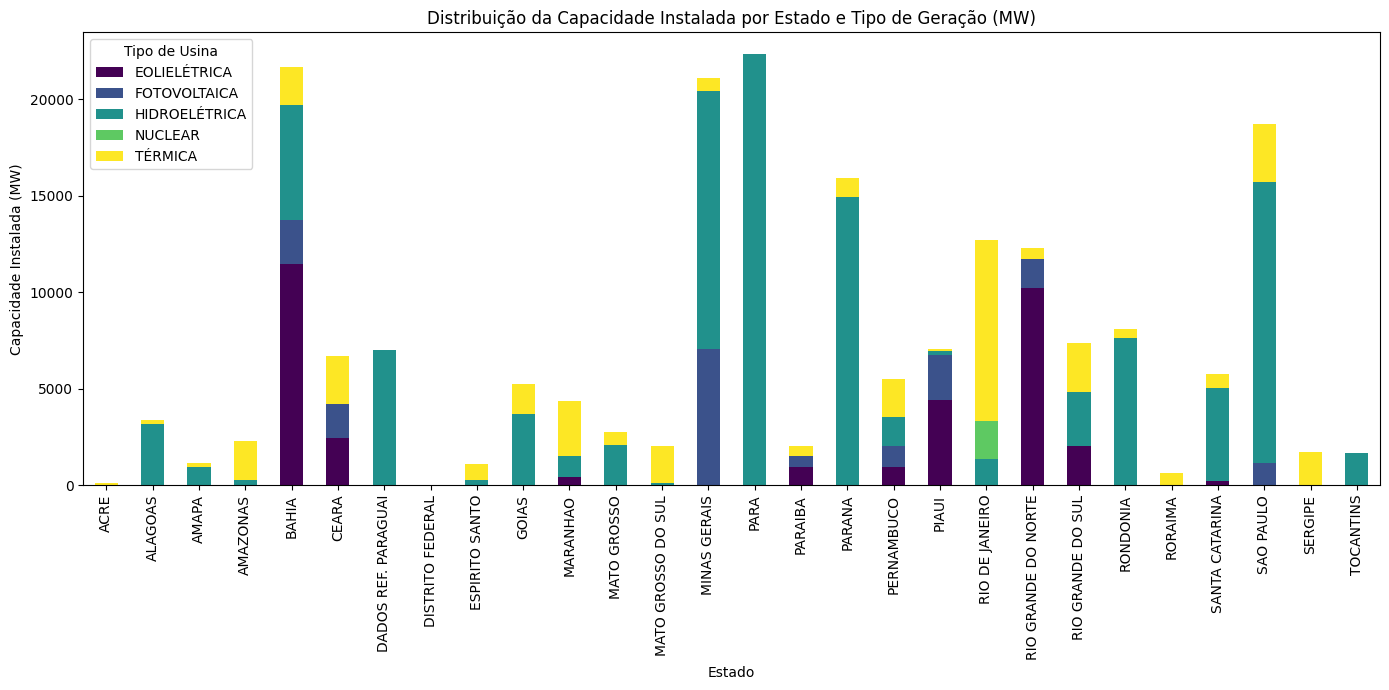

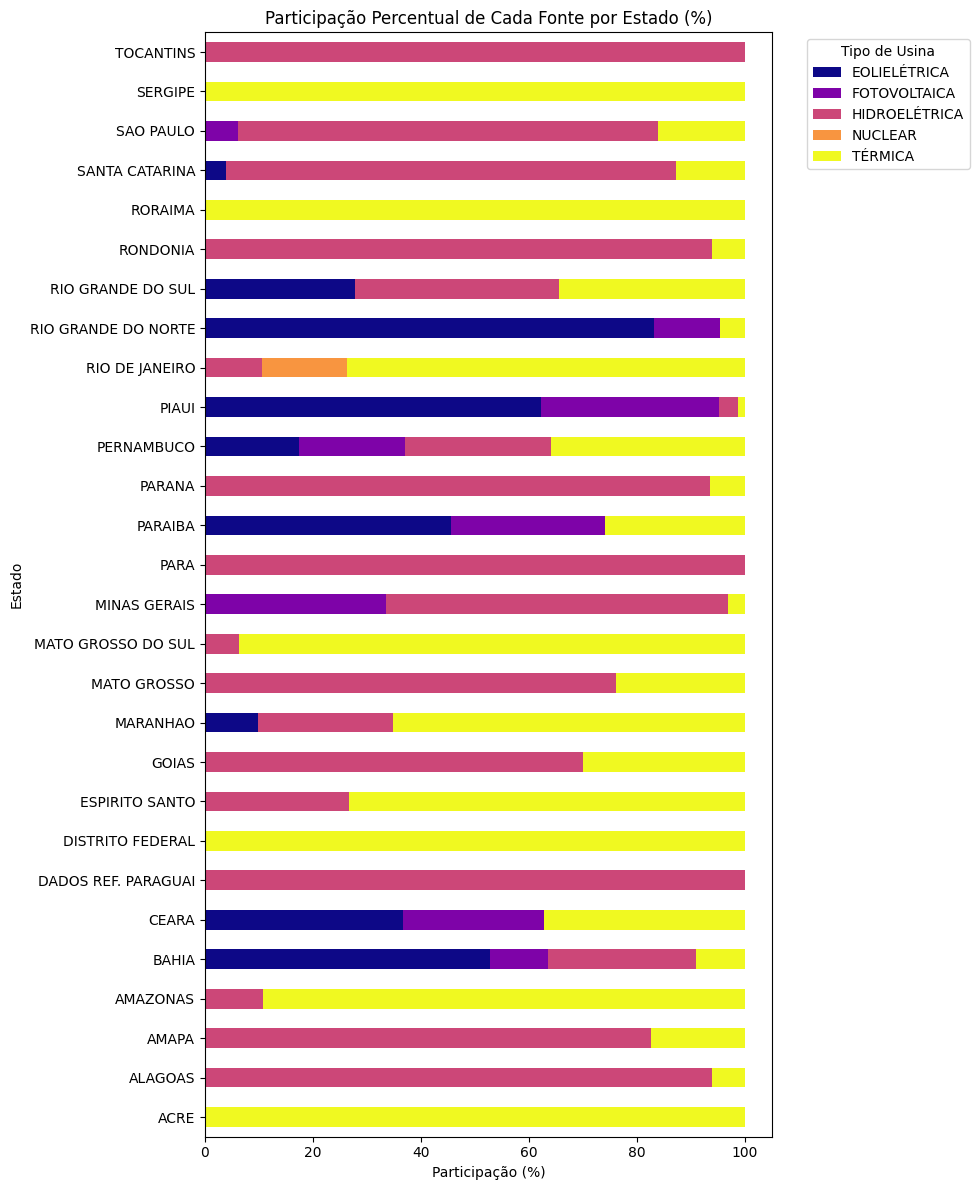

Estados líderes por tipo de geração:

   Tipo de Usina    Estado Líder  Capacidade (MW)
0   EOLIELÉTRICA           BAHIA      11440.05000
1   FOTOVOLTAICA    MINAS GERAIS       7070.80104
2  HIDROELÉTRICA            PARA      22330.68000
3        NUCLEAR  RIO DE JANEIRO       1990.00000
4        TÉRMICA  RIO DE JANEIRO       9390.79400

Estado líder em energia solar:
Não encontrado

Estado líder em energia eólica:
  Tipo de Usina Estado Líder  Capacidade (MW)
0  EOLIELÉTRICA        BAHIA         11440.05


/tmp/ipython-input-3970540139.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x['val_potenciaefetiva'].idxmax(), ['nom_estado', 'val_potenciaefetiva']])


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

df_raw = pd.read_csv("CAPACIDADE_GERACAO.csv", sep=None, engine='python')

if df_raw.shape[1] == 1:
    df_raw = df_raw[df_raw.columns[0]].str.split(';', expand=True)

df_raw.columns = [
    "id_subsistema", "nom_subsistema", "id_estado", "nom_estado",
    "nom_modalidadeoperacao", "nom_agenteproprietario", "nom_agenteoperador",
    "nom_tipousina", "nom_usina", "ceg", "nom_unidadegeradora",
    "cod_equipamento", "num_unidadegeradora", "nom_combustivel",
    "dat_entradateste", "dat_entradaoperacao", "dat_desativacao",
    "val_potenciaefetiva"
]

df = df_raw[['nom_estado', 'nom_tipousina', 'val_potenciaefetiva']].copy()
df['val_potenciaefetiva'] = pd.to_numeric(df['val_potenciaefetiva'], errors='coerce')
df = df.dropna()

df_estado = (
    df.groupby(['nom_estado', 'nom_tipousina'])['val_potenciaefetiva']
    .sum()
    .reset_index()
)

df_estado['Perc_Estado'] = (
    df_estado['val_potenciaefetiva'] /
    df_estado.groupby('nom_estado')['val_potenciaefetiva'].transform('sum')
) * 100

df_pivot_estado = df_estado.pivot(index='nom_estado',
                                  columns='nom_tipousina',
                                  values='val_potenciaefetiva').fillna(0)

df_pivot_estado.sort_index(inplace=True)

plt.figure(figsize=(14, 7))
df_pivot_estado.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title("Distribuição da Capacidade Instalada por Estado e Tipo de Geração (MW)")
plt.xlabel("Estado")
plt.ylabel("Capacidade Instalada (MW)")
plt.legend(title="Tipo de Usina")
plt.tight_layout()
plt.show()

df_pivot_perc = df_estado.pivot(index='nom_estado',
                                columns='nom_tipousina',
                                values='Perc_Estado').fillna(0)

df_pivot_perc.plot(kind='barh', stacked=True, figsize=(10, 12), colormap='plasma')
plt.title("Participação Percentual de Cada Fonte por Estado (%)")
plt.xlabel("Participação (%)")
plt.ylabel("Estado")
plt.legend(title="Tipo de Usina", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

lideres = (
    df_estado.groupby('nom_tipousina')
    .apply(lambda x: x.loc[x['val_potenciaefetiva'].idxmax(), ['nom_estado', 'val_potenciaefetiva']])
    .reset_index()
    .rename(columns={'nom_tipousina': 'Tipo de Usina', 'nom_estado': 'Estado Líder', 'val_potenciaefetiva': 'Capacidade (MW)'})
)

print("Estados líderes por tipo de geração:\n")
print(lideres)

solar = lideres[lideres['Tipo de Usina'].str.contains('SOLAR', case=False)]
eolica = lideres[lideres['Tipo de Usina'].str.contains('EOL', case=False)]

print("\nEstado líder em energia solar:")
print(solar if not solar.empty else "Não encontrado")

print("\nEstado líder em energia eólica:")
print(eolica if not eolica.empty else "Não encontrado")




# Exercício 3 – Previsão de Crescimento da Capacidade Solar

### Contexto
A energia solar tem crescido exponencialmente no Brasil. Podemos usar aprendizado de máquina para prever a capacidade futura.

### Atividade
1. Filtrar os dados apenas para usinas solares.  
2. Criar uma série temporal da capacidade instalada por ano.  
3. Aplicar um modelo de regressão (LinearRegression ou RandomForestRegressor).  
4. Fazer previsões para os próximos 5 anos.  
5. Pergunta: O modelo indica crescimento linear ou exponencial?


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


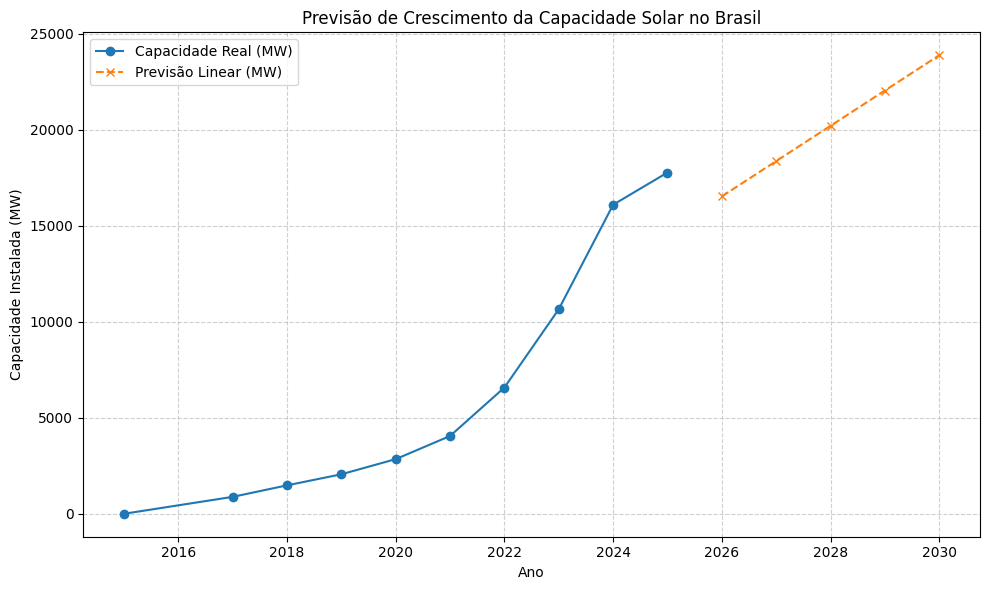

Previsão para 2026: 16,541 MW
Previsão para 2027: 18,379 MW
Previsão para 2028: 20,216 MW
Previsão para 2029: 22,053 MW
Previsão para 2030: 23,891 MW

O modelo indica um crescimento linear da capacidade solar.


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

df_raw = pd.read_csv("CAPACIDADE_GERACAO.csv", sep=None, engine='python')

if df_raw.shape[1] == 1:
    df_raw = df_raw[df_raw.columns[0]].str.split(';', expand=True)

df_raw.columns = [
    "id_subsistema", "nom_subsistema", "id_estado", "nom_estado",
    "nom_modalidadeoperacao", "nom_agenteproprietario", "nom_agenteoperador",
    "nom_tipousina", "nom_usina", "ceg", "nom_unidadegeradora",
    "cod_equipamento", "num_unidadegeradora", "nom_combustivel",
    "dat_entradateste", "dat_entradaoperacao", "dat_desativacao",
    "val_potenciaefetiva"
]

df_raw['dat_entradaoperacao'] = pd.to_datetime(df_raw['dat_entradaoperacao'], errors='coerce')
df_raw['val_potenciaefetiva'] = pd.to_numeric(df_raw['val_potenciaefetiva'], errors='coerce')

df_solar = df_raw[df_raw['nom_tipousina'].str.contains('SOLAR|FOTOVOLTAICA|UFV', case=False, na=False)]
df_solar = df_solar.dropna(subset=['dat_entradaoperacao', 'val_potenciaefetiva'])

df_solar['Ano'] = df_solar['dat_entradaoperacao'].dt.year
df_ano = df_solar.groupby('Ano')['val_potenciaefetiva'].sum().reset_index()

if df_ano.empty:
    print("Nenhum dado de usinas solares foi encontrado no arquivo. Verifique o conteúdo do CSV.")
else:
    df_ano['Capacidade_Acumulada'] = df_ano['val_potenciaefetiva'].cumsum()
    X = df_ano[['Ano']]
    y = df_ano['Capacidade_Acumulada']

    modelo = LinearRegression()
    modelo.fit(X, y)

    anos_futuros = np.arange(df_ano['Ano'].max() + 1, df_ano['Ano'].max() + 6).reshape(-1, 1)
    previsoes = modelo.predict(anos_futuros)

    plt.figure(figsize=(10, 6))
    plt.plot(df_ano['Ano'], y, label='Capacidade Real (MW)', marker='o')
    plt.plot(anos_futuros, previsoes, label='Previsão Linear (MW)', linestyle='--', marker='x')
    plt.title("Previsão de Crescimento da Capacidade Solar no Brasil")
    plt.xlabel("Ano")
    plt.ylabel("Capacidade Instalada (MW)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    for ano, prev in zip(anos_futuros.flatten(), previsoes):
        print(f"Previsão para {ano}: {prev:,.0f} MW")

    if modelo.coef_[0] > 0:
        print("\nO modelo indica um crescimento linear da capacidade solar.")
    else:
        print("\nO modelo não indica crescimento no período.")




# Exercício 4 – Classificação de Usinas por Fonte

### Contexto
Podemos treinar um modelo de classificação para prever o tipo de geração de uma usina a partir de suas características.

### Atividade
1. Usar variáveis como capacidade, estado, data de operação.  
2. Dividir os dados em treino/teste.  
3. Treinar um modelo de classificação (Decision Tree ou Random Forest).  
4. Avaliar a acurácia do modelo.  
5. Pergunta: Quais variáveis mais influenciam na classificação de uma usina?


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

df_raw = pd.read_csv("CAPACIDADE_GERACAO.csv", sep=None, engine='python')

if df_raw.shape[1] == 1:
    df_raw = df_raw[df_raw.columns[0]].str.split(';', expand=True)

df_raw.columns = [
    "id_subsistema", "nom_subsistema", "id_estado", "nom_estado",
    "nom_modalidadeoperacao", "nom_agenteproprietario", "nom_agenteoperador",
    "nom_tipousina", "nom_usina", "ceg", "nom_unidadegeradora",
    "cod_equipamento", "num_unidadegeradora", "nom_combustivel",
    "dat_entradateste", "dat_entradaoperacao", "dat_desativacao",
    "val_potenciaefetiva"
]

df = df_raw[['nom_estado', 'dat_entradaoperacao', 'val_potenciaefetiva', 'nom_tipousina']].copy()
df['val_potenciaefetiva'] = pd.to_numeric(df['val_potenciaefetiva'], errors='coerce')
df['dat_entradaoperacao'] = pd.to_datetime(df['dat_entradaoperacao'], errors='coerce')
df = df.dropna(subset=['nom_estado', 'dat_entradaoperacao', 'val_potenciaefetiva', 'nom_tipousina'])

df['Ano'] = df['dat_entradaoperacao'].dt.year

le_estado = LabelEncoder()
le_tipo = LabelEncoder()

df['Estado_cod'] = le_estado.fit_transform(df['nom_estado'])
df['Tipo_cod'] = le_tipo.fit_transform(df['nom_tipousina'])

X = df[['val_potenciaefetiva', 'Ano', 'Estado_cod']]
y = df['Tipo_cod']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

modelo = RandomForestClassifier(random_state=42, n_estimators=200)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Acurácia do modelo: {acc:.2f}\n")

classes_teste = np.unique(np.concatenate((y_test, y_pred)))
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, labels=classes_teste, target_names=le_tipo.inverse_transform(classes_teste)))

importancias = pd.Series(modelo.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nImportância das variáveis:")
print(importancias)


Acurácia do modelo: 0.97

Relatório de Classificação:
               precision    recall  f1-score   support

 EOLIELÉTRICA       0.97      0.98      0.98       530
 FOTOVOLTAICA       0.97      0.95      0.96       250
HIDROELÉTRICA       0.96      0.98      0.97       205
      TÉRMICA       0.99      0.97      0.98       366

     accuracy                           0.97      1351
    macro avg       0.97      0.97      0.97      1351
 weighted avg       0.97      0.97      0.97      1351


Importância das variáveis:
val_potenciaefetiva    0.420840
Ano                    0.342719
Estado_cod             0.236441
dtype: float64



# Exercício 5 – Agrupamento de Usinas por Perfil

### Contexto
Usinas podem ser agrupadas de acordo com sua capacidade, região e tipo de geração, revelando padrões na matriz elétrica.

### Atividade
1. Selecionar variáveis numéricas (capacidade, ano de operação, latitude/longitude se disponíveis).  
2. Aplicar o algoritmo de clusterização K-Means.  
3. Visualizar os clusters em gráfico de dispersão.  
4. Pergunta: Cada grupo representa qual perfil de usinas (pequenas solares, grandes hidráulicas, etc.)?


Médias por cluster:
         val_potenciaefetiva          Ano
Cluster                                  
0                  25.177594  2003.559508
1                  20.048534  2019.862975
2                 454.236104  1999.770833
3                  96.313297  1968.641638

Distribuição por tipo de usina:
Cluster  nom_tipousina
0        TÉRMICA          1118
         HIDROELÉTRICA     271
         EOLIELÉTRICA       73
1        EOLIELÉTRICA     2047
         FOTOVOLTAICA      998
         TÉRMICA           284
         HIDROELÉTRICA     174
2        HIDROELÉTRICA     118
         TÉRMICA            24
         NUCLEAR             2
Name: count, dtype: int64


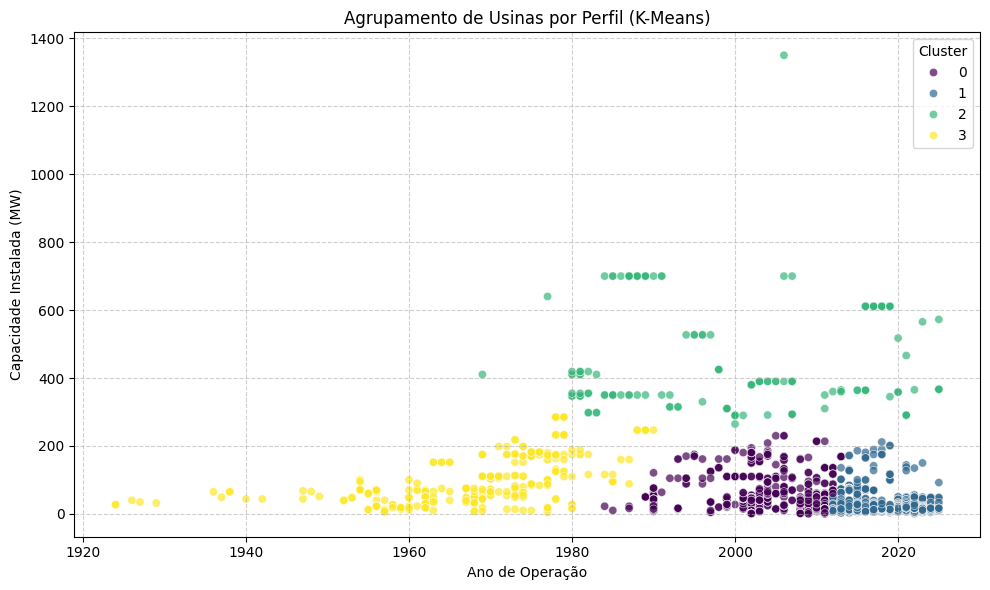

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

df_raw = pd.read_csv("CAPACIDADE_GERACAO.csv", sep=None, engine='python')

if df_raw.shape[1] == 1:
    df_raw = df_raw[df_raw.columns[0]].str.split(';', expand=True)

df_raw.columns = [
    "id_subsistema", "nom_subsistema", "id_estado", "nom_estado",
    "nom_modalidadeoperacao", "nom_agenteproprietario", "nom_agenteoperador",
    "nom_tipousina", "nom_usina", "ceg", "nom_unidadegeradora",
    "cod_equipamento", "num_unidadegeradora", "nom_combustivel",
    "dat_entradateste", "dat_entradaoperacao", "dat_desativacao",
    "val_potenciaefetiva"
]

df_raw['dat_entradaoperacao'] = pd.to_datetime(df_raw['dat_entradaoperacao'], errors='coerce')
df_raw['val_potenciaefetiva'] = pd.to_numeric(df_raw['val_potenciaefetiva'], errors='coerce')
df_raw = df_raw.dropna(subset=['val_potenciaefetiva', 'dat_entradaoperacao', 'nom_tipousina', 'nom_estado'])

df_raw['Ano'] = df_raw['dat_entradaoperacao'].dt.year

df_cluster = df_raw[['val_potenciaefetiva', 'Ano']].copy()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

kmeans = KMeans(n_clusters=4, random_state=42)
df_raw['Cluster'] = kmeans.fit_predict(df_scaled)

cluster_summary = df_raw.groupby('Cluster')[['val_potenciaefetiva', 'Ano']].mean()
print("Médias por cluster:")
print(cluster_summary)
print("\nDistribuição por tipo de usina:")
print(df_raw.groupby('Cluster')['nom_tipousina'].value_counts().head(10))

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_raw,
    x='Ano',
    y='val_potenciaefetiva',
    hue='Cluster',
    palette='viridis',
    alpha=0.7
)
plt.title("Agrupamento de Usinas por Perfil (K-Means)")
plt.xlabel("Ano de Operação")
plt.ylabel("Capacidade Instalada (MW)")
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



# Entrega Final

Cada exercício deve ser entregue em notebook final, vinculado a um repositório do GitHub.  
O relatório final deve conter:
- Código comentado  
- Gráficos e tabelas  
- Respostas às perguntas interpretativas
